In [64]:
# Setup
import time
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#!pip install rasterio
import rasterio
from scipy.ndimage import generic_filter

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# D8 direction encoding and decoding
D8_DIRECTIONS = {
    (1, 0): 1,   # East
    (1, -1): 2,  # Southeast
    (0, -1): 4,  # South
    (-1, -1): 8, # Southwest
    (-1, 0): 16, # West
    (-1, 1): 32, # Northwest
    (0, 1): 64,  # North
    (1, 1): 128  # Northeast
}

DIRECTION_VECTORS = {v: k for k, v in D8_DIRECTIONS.items()}

In [66]:
def Read(tif_file):
    start_time = time.time()
    with rasterio.open(tif_file) as src:
        elevation = src.read(1)
        print(elevation)
        transform = src.transform
        crs = src.crs
        print(crs)
        print(transform)

    height, width = elevation.shape
    print(f"Raster dimensions: {height} rows, {width} columns")

    rows, cols = np.indices((height, width))
    lons, lats = transform * (cols, rows)
    print(lons)
    lon_diff = abs(transform[0])  # Pixel width
    lat_diff = abs(transform[4])  # Pixel height

    read_time = time.time() - start_time
    print(f"Reading DEM took {read_time:.2f} seconds")
    return elevation, lons, lats, lon_diff, lat_diff

In [67]:
def find_depressions(elevation):
    height, width = elevation.shape

    def replace_lowest(center, neighbors):
        if center < np.min(neighbors):
            return np.min(neighbors)
        return center

    new_elevation = elevation.copy()

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            center = elevation[y, x]
            neighbors = [
                elevation[y-1, x-1], elevation[y-1, x], elevation[y-1, x+1],
                elevation[y, x-1],                     elevation[y, x+1],
                elevation[y+1, x-1], elevation[y+1, x], elevation[y+1, x+1]
            ]
            new_elevation[y, x] = replace_lowest(center, neighbors)

    elevation[:] = new_elevation
    return elevation

In [68]:
def D8(elevation, lons, lats, lon_diff, lat_diff):
    start_time = time.time()
    height, width = elevation.shape

    directions_grid = np.zeros_like(elevation, dtype=np.uint8)
    for x in range(width):
      for y in range(height):
        max_dist = 0
        best_code = 0
        for (dx, dy), code in D8_DIRECTIONS.items():
           nx = x + dx
           ny = y - dy
           # Ensure the neighbor is within bounds
           if 0 <= nx < width and 0 <= ny < height:
              # Compute the descent
              descent = (elevation[y, x] - elevation[ny, nx]) / np.hypot(dx, dy)

              # Update max direction and max distance
              if descent > max_dist:
                max_dist = descent
                best_code = code

              elif descent == max_dist and descent > 0:
                best_code |= code # Add the path #s together
        # Assign the direction code to the grid
        directions_grid[y, x] = best_code
    d8_time = time.time() - start_time
    print(f"D8 flow analysis took {d8_time:.2f} seconds")
    return directions_grid

In [69]:
from scipy.ndimage import correlate
def Accumulation(direction_grid):
    rows, cols = direction_grid.shape
    accumulation_grid = np.zeros((rows, cols), dtype=int)

    # Create a kernel to accumulate flow contributions
    kernel = np.zeros((3, 3), dtype=int)

    for (x,y), code in D8_DIRECTIONS.items():
        kernel.fill(0)
        kernel[1 + x, 1 + y] = 1
        accumulation_grid += correlate(direction_grid == code, kernel, mode='constant', cval=0)

    return accumulation_grid


In [70]:
def plot_boundary_elevation(elevation):
    plt.figure(figsize=(10, 10))
    plt.imshow(elevation, cmap='terrain')
    plt.title('Elevation')
    plt.colorbar()
    plt.show()

def plot_directions(directions_grid):
    plt.figure(figsize=(10, 10))
    plt.imshow(directions_grid, cmap='tab20b', vmin=0, vmax=255)
    plt.colorbar()
    plt.title('D8 Flow Directions')
    plt.show()

# Call these functions to visualize


In [71]:
def plot_results(elevation, directions_grid, accumulation_grid, lons, lats, lon_diff, lat_diff):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    x_min, x_max = lons.min() - lon_diff / 2, lons.max() + lon_diff / 2
    y_min, y_max = lats.min() - lat_diff / 2, lats.max() + lat_diff / 2

    axs[0].set_xlim(x_min, x_max)
    axs[0].set_ylim(y_min, y_max)
    axs[0].set_xticks(np.arange(x_min, x_max + lon_diff, lon_diff))
    axs[0].set_yticks(np.arange(y_min, y_max + lat_diff, lat_diff))
    axs[0].grid(True)
    axs[0].set_title('Direction Codes')

    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)
    axs[1].set_xticks(np.arange(x_min, x_max + lon_diff, lon_diff))
    axs[1].set_yticks(np.arange(y_min, y_max + lat_diff, lat_diff))
    axs[1].grid(True)
    axs[1].set_title('Steepest Descent Arrows')

    for i in range(lons.shape[0]):
        for j in range(lons.shape[1]):
            xi, yi = lons[i, j], lats[i, j]
            direction_code = directions_grid[i, j]
            elevation_value = elevation[i, j]
            accumulation_value = accumulation_grid[i, j]

            # Plot direction codes
          #  axs[0].text(xi, yi, str(direction_code), ha='center', va='center', fontsize=30)
            if direction_code != 0:
                for code, vector in DIRECTION_VECTORS.items():
                    if direction_code & code:
                        dx, dy = vector
                        axs[0].arrow(xi, yi, dx * lon_diff * .7, dy * lat_diff * .7, head_width=lon_diff * 0.1, head_length=lat_diff * 0.1, fc='red', ec='red')

            # Plot steepest descent arrows
            axs[1].text(xi, yi, f'{accumulation_value:.1f}', ha='center', va='center', fontsize=8)
            if direction_code != 0:
                for code, vector in DIRECTION_VECTORS.items():
                    if direction_code & code:
                        dx, dy = vector
                    #    axs[1].arrow(xi, yi, dx * lon_diff * 0.4, dy * lat_diff * 0.4, head_width=lon_diff * 0.2, head_length=lat_diff * 0.1, fc='red', ec='red')


    plt.show()

[[1040.45 1040.57 1040.68 ... 1105.22 1105.25 1105.3 ]
 [1040.4  1040.54 1040.63 ... 1105.24 1105.28 1105.31]
 [1040.37 1040.5  1040.59 ... 1105.25 1105.28 1105.31]
 ...
 [ 999.25  999.29  999.39 ... 1113.34 1113.34 1113.3 ]
 [ 998.28  998.4   998.52 ... 1113.31 1113.32 1113.27]
 [ 997.28  997.43  997.63 ... 1113.28 1113.26 1113.22]]
EPSG:6549
| 1.25, 0.00, 2173750.00|
| 0.00,-1.25, 607500.00|
| 0.00, 0.00, 1.00|
Raster dimensions: 1000 rows, 1000 columns
[[2173750.   2173751.25 2173752.5  ... 2174996.25 2174997.5  2174998.75]
 [2173750.   2173751.25 2173752.5  ... 2174996.25 2174997.5  2174998.75]
 [2173750.   2173751.25 2173752.5  ... 2174996.25 2174997.5  2174998.75]
 ...
 [2173750.   2173751.25 2173752.5  ... 2174996.25 2174997.5  2174998.75]
 [2173750.   2173751.25 2173752.5  ... 2174996.25 2174997.5  2174998.75]
 [2173750.   2173751.25 2173752.5  ... 2174996.25 2174997.5  2174998.75]]
Reading DEM took 0.64 seconds
Sample data from the coordinates and elevation array:
[[1040.45 10

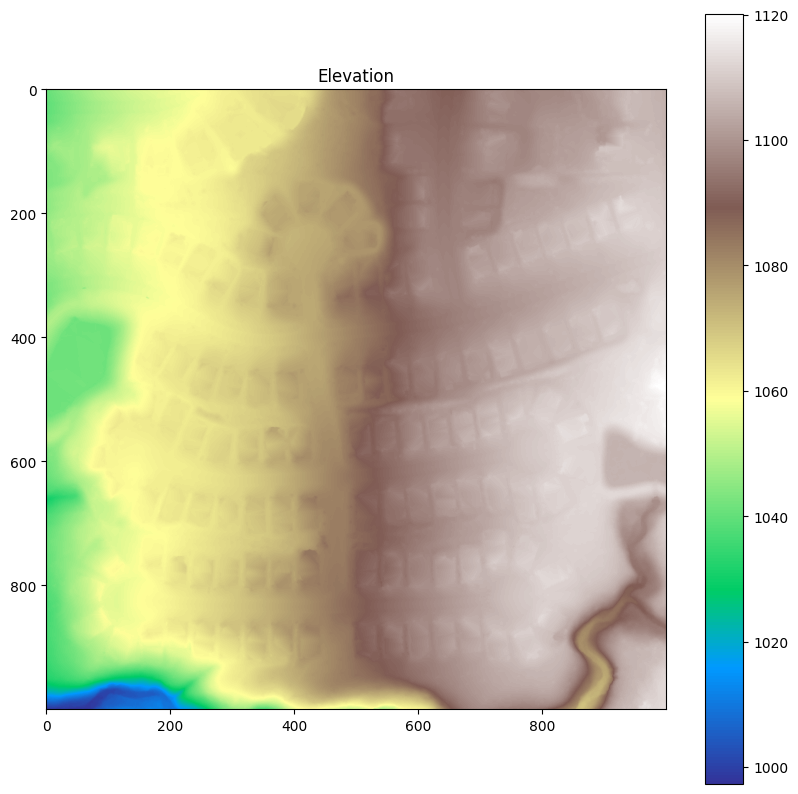

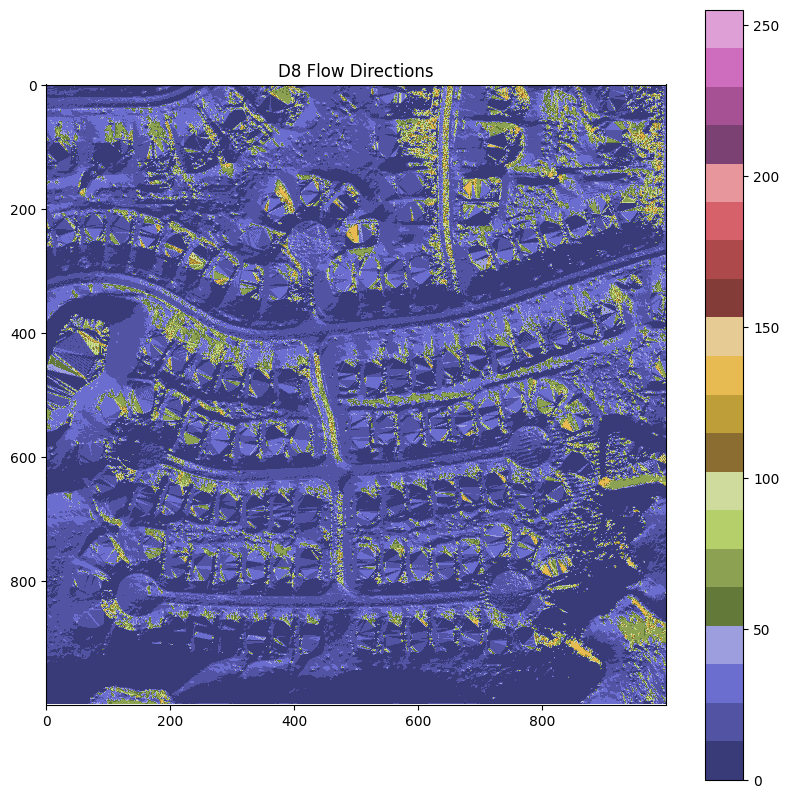

array([[ 4,  8, 16, ..., 16, 16, 16],
       [ 4, 16,  8, ..., 16, 32, 32],
       [ 4, 16,  8, ..., 32, 16, 16],
       ...,
       [ 4,  4,  4, ..., 32,  2,  4],
       [ 4,  4,  4, ...,  2,  2,  4],
       [ 0, 16, 16, ...,  1,  1,  0]], dtype=uint8)
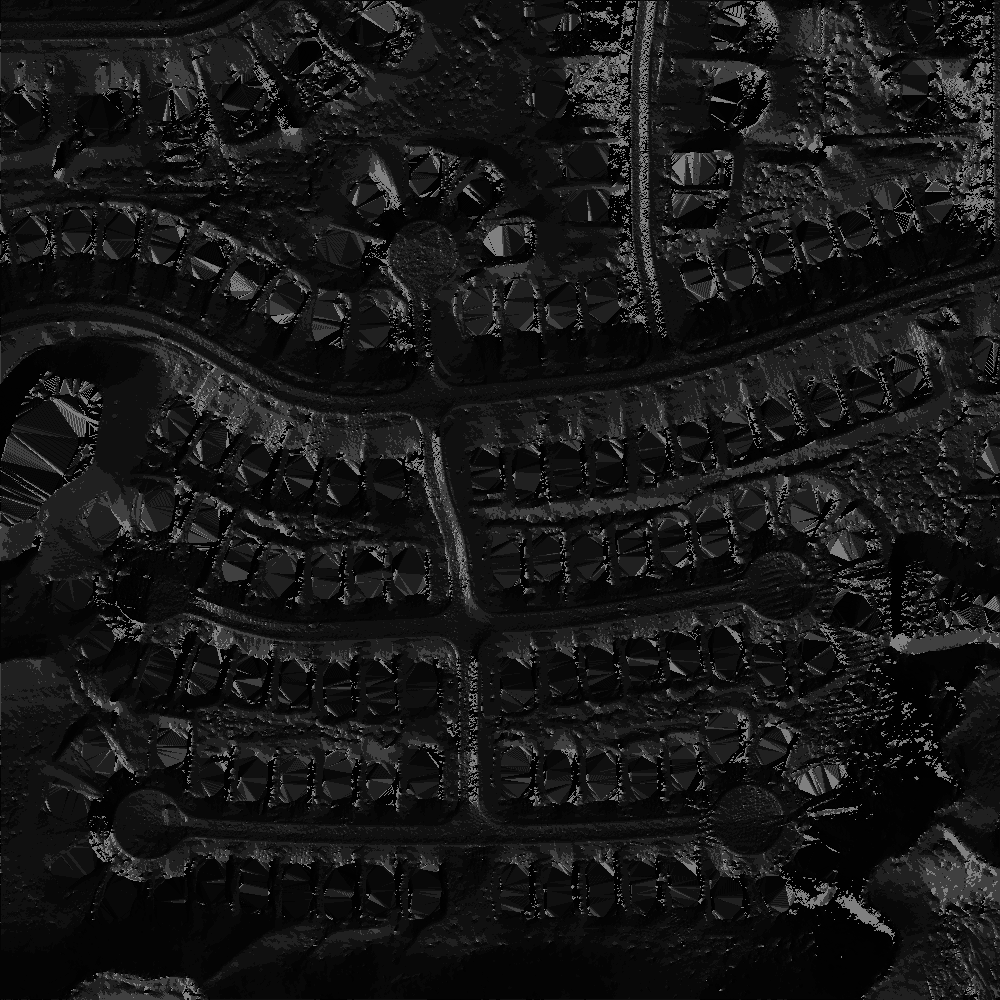

In [72]:
def main(tif_file):
    elevation, lons, lats, lon_diff, lat_diff = Read(tif_file)
    print(f"Sample data from the coordinates and elevation array:")
    print(elevation[:5])  # Print the first 5 entries for inspection
   # print(f"Longitude difference: {lon_diff}")
    #print(f"Latitude difference: {lat_diff}")
    #elevation = find_depressions(elevation)
    directions_grid = D8(elevation, lons, lats, lon_diff, lat_diff)
   # print(f"Sample data from the directions grid:")
   # sample_data = list(zip(lons.flatten(), lats.flatten(), directions_grid.flatten()))[:5]  # Convert to list and take first 5 entries
    #for lon, lat, code in sample_data:
       # print(f"Location: ({lon}, {lat}), Direction Code: {code}")
    plot_boundary_elevation(elevation)
    plot_directions(directions_grid)
    #accumulation_grid = Accumulation(directions_grid)
    #plot_results(elevation, directions_grid, accumulation_grid, lons, lats, lon_diff, lat_diff)
    return directions_grid

# Run the main function
tif_file = '/content/drive/MyDrive/mySEES/USGS_OPR_OH_Statewide_Phase1_2019_B19_BN21730606.tif'
main(tif_file)


In [73]:
"""# Trace flow off one pixel
def trace_water_flow(start_lon, start_lat, directions_grid, lon_diff, lat_diff):
    path = [(start_lon, start_lat)]  # Initialize path
    current_lon, current_lat = start_lon, start_lat

    while True:
        direction_code = directions_grid.get((current_lon, current_lat), 0)
        if direction_code == 0:
            break

        next_step = None
        for code, vector in DIRECTION_VECTORS.items():
            if direction_code & code:
                next_step = vector
                break

        if next_step is None:
            break

        dx, dy = next_step
        next_lon = current_lon + dx * lon_diff
        next_lat = current_lat + dy * lat_diff

        if (next_lon, next_lat) in directions_grid:
            current_lon, current_lat = next_lon, next_lat
            path.append((current_lon, current_lat))
        else:
            break

    return path"""

'# Trace flow off one pixel\ndef trace_water_flow(start_lon, start_lat, directions_grid, lon_diff, lat_diff):\n    path = [(start_lon, start_lat)]  # Initialize path\n    current_lon, current_lat = start_lon, start_lat\n\n    while True:\n        direction_code = directions_grid.get((current_lon, current_lat), 0)\n        if direction_code == 0:\n            break\n\n        next_step = None\n        for code, vector in DIRECTION_VECTORS.items():\n            if direction_code & code:\n                next_step = vector\n                break\n\n        if next_step is None:\n            break\n\n        dx, dy = next_step\n        next_lon = current_lon + dx * lon_diff\n        next_lat = current_lat + dy * lat_diff\n\n        if (next_lon, next_lat) in directions_grid:\n            current_lon, current_lat = next_lon, next_lat\n            path.append((current_lon, current_lat))\n        else:\n            break\n\n    return path'